<a href="https://colab.research.google.com/github/Mamedova-S/VKR_Mamedova/blob/main/src/text/LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
import pickle

## Загрузка датасета

In [ ]:
# data_depressive= pd.read_pickle ("/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/preprocessing_suicide.pkl")
combined_df= pd.read_pickle ('/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/combined_df.pkl')
combined_df2= pd.read_pickle ('/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/combined_df2.pkl')

X = combined_df2['preprocess_text']
y = combined_df2['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Word2Vec

In [ ]:
embedding_file = '/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/GoogleNews-vectors-negative300.bin.gz'
max_length = 280
max_nb_words = 25000
embedding_dim = 300



tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

with open('/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/tokenizer_combined_df.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)


word2vec = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
#The embedding matrix
vocab_size_wv = min(max_nb_words, len(tokenizer.word_index))

embedding_matrix_wv = np.zeros((vocab_size_wv, embedding_dim))

for (word, idx) in tokenizer.word_index.items():
    if word in word2vec.key_to_index and idx < max_nb_words:
        embedding_matrix_wv[idx] = word2vec.word_vec(word)

<ipython-input-4-5cd06fb48e26>:28: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_matrix_wv[idx] = word2vec.word_vec(word)


## Построение архитектуры и обучение модели

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size_wv, output_dim=embedding_dim, 
                    weights=[embedding_matrix_wv], input_length=max_length, 
                    trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), 
          epochs=5, batch_size=64)




Epoch 1/5
2345/2345 [==============================] - 2614s 1s/step - loss: 0.3258 - accuracy: 0.8705 - val_loss: 0.2865 - val_accuracy: 0.8888
Epoch 2/5
2345/2345 [==============================] - 2536s 1s/step - loss: 0.2656 - accuracy: 0.8959 - val_loss: 0.2491 - val_accuracy: 0.9030
Epoch 3/5
2345/2345 [==============================] - 2538s 1s/step - loss: 0.2353 - accuracy: 0.9079 - val_loss: 0.2316 - val_accuracy: 0.9106
Epoch 4/5
2345/2345 [==============================] - 2564s 1s/step - loss: 0.2189 - accuracy: 0.9144 - val_loss: 0.2303 - val_accuracy: 0.9105
Epoch 5/5
2345/2345 [==============================] - 2580s 1s/step - loss: 0.2075 - accuracy: 0.9188 - val_loss: 0.2248 - val_accuracy: 0.9124


## Графики

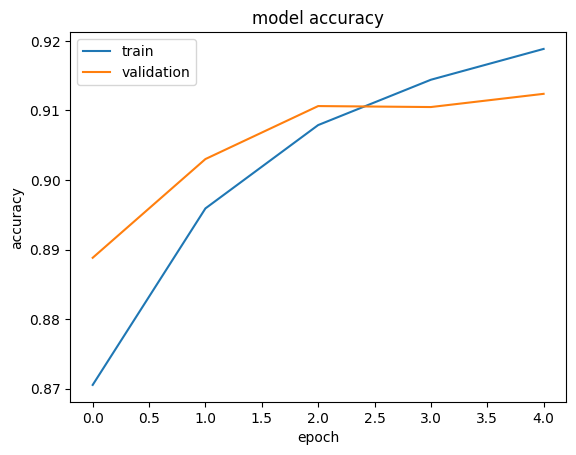

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

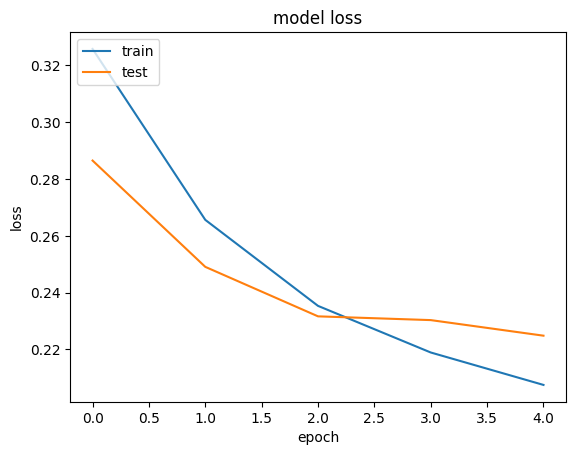

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/LSTM_2.h5")

df = pd.DataFrame(history.history)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/LSTM_2.csv', index=False)
